# Pipelines
* Recent: less than 30 days
* Old: 30 days
* Stale: 90 days

In [1]:
# include common code and config
# selected_pi = 16
%run PIQM_Bootstrap.ipynb

Current PI: {'pi': 'PI16', 'id': 16, 'start': '2022-09-14T00:00:00Z', 'started': '2022-09-14', 'finish': '2022-12-13T23:59:59Z'}
Last start: 2022-09-14T00:00:00Z


In [20]:
# MVP related projects from:
# https://gitlab.com/ska-telescope/ska-skampi/-/blob/master/charts/ska-mid/Chart.yaml
# https://gitlab.com/ska-telescope/ska-skampi/-/blob/master/charts/ska-low/Chart.yaml
project_ids = [ 11448712, # ska-skampi
                # 9027158,  # ska-tango-images
                23023505, # ska-tmc-centralnode
                21141217, # sdp/ska-sdp-integration
                32606296, # ska-tango-taranta-group/ska-tango-taranta-pipeline
                #32606403, # ska-tango-taranta-group/ska-tango-taranta-auth-pipeline
                #32606458, # ska-tango-taranta-group/ska-tango-taranta-dashboard-pipeline
                #17415960, # ska-ser-skuid
                # 15858077, # ska-dish-lmc
                # 10593884, # ska-sim-dishmaster
                #23023437, # ska-tmc-subarraynode
                10749136, # ska-tmc
                #21173098, # ska-ser-skallop, ska-log-consumer
                # 12488466, # https://gitlab.com/ska-telescope/ska-mid-cbf-mcs - gives ska-mid-cbf
                # 15856638, # https://gitlab.com/ska-telescope/ska-low-cbf
                # 25588162, # https://gitlab.com/ska-telescope/ska-csp-lmc-low
                # 25578388, # https://gitlab.com/ska-telescope/ska-csp-lmc-mid
                #19426925, # https://gitlab.com/ska-telescope/ska-low-cbf-proc
              ]



In [21]:
from datetime import datetime
current_timestamp = int(datetime.now().timestamp())
query_api = client.query_api()
df_pipelines = query_api.query_data_frame(
    """from(bucket: "gitlab_metrics") 
        |> range(start: 2008-01-01T00:00:00Z, stop: {0[finish]}) 
        |> filter(fn: (r) => r._measurement == "projects" and r._field == "pipeline_last_run_finished")
        |> drop(columns:["_measurement", "_field", "_time", "_start", "_stop"])
        |> group()""".format(current_pi))
# .agg(['count', 'size', 'nunique'])
df_pipeline_status = df_pipelines[["pipeline_last_run_status", "_value"]].groupby(["pipeline_last_run_status"]).agg(['count', 'size', 'nunique']).reset_index()
df_pipeline_status['pipeline_last_run_status'] = df_pipeline_status['pipeline_last_run_status'].str.title()
df_pipeline_status['count'] = df_pipeline_status['_value']['count']
# print(df_pipeline_status)
old_threshold = 30 * 24 * 60 * 60 # 30 days
stale_threshold = 90 * 24 * 60 * 60 # 90 days
df_pipelines['age'] = current_timestamp - df_pipelines['_value']
df_pipelines["stale_pipeline"] = pandas.cut(x=df_pipelines['age'],
                                            bins=[0, 1, old_threshold, stale_threshold, float('Inf')],
                                            labels=['Never', 'Recent', 'Old', 'Stale'], right=False)

df_pipelines.loc[df_pipelines['_value'] < 1,'stale_pipeline'] = 'Never'
df_pipelines['how_many'] = 1
df_pipelines['total'] = 'Total'
df_pipelines

/home/piers/.cache/pypoetry/virtualenvs/ska-cicd-gitlab-metrics-rcCqCUGS-py3.10/lib/python3.10/site-packages/influxdb_client/client/warnings.py:31: MissingPivotFunction:

The query doesn't contains the pivot() function.

The result will not be shaped to optimal processing by pandas.DataFrame. Use the pivot() function by:

    from(bucket: "gitlab_metrics") 
        |> range(start: 2008-01-01T00:00:00Z, stop: 2022-12-13T23:59:59Z) 
        |> filter(fn: (r) => r._measurement == "projects" and r._field == "pipeline_last_run_finished")
        |> drop(columns:["_measurement", "_field", "_time", "_start", "_stop"])
        |> group() |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

You can disable this warning by:
    import warnings
    from influxdb_client.client.warnings import MissingPivotFunction

    warnings.simplefilter("ignore", MissingPivotFunction)

For more info see:
    - https://docs.influxdata.com/resources/videos/pivots-in-flux/
    - https://docs.i

result  table        _value got_coverage got_linting got_rtd got_tests  \
0    _result      0  1.669263e+09            0           0       0         0   
1    _result      0  1.667378e+09            0           0       0         0   
2    _result      0  1.668971e+09            0           0       0         0   
3    _result      0  1.669263e+09            0           0       0         0   
4    _result      0  1.662431e+09            0           0       0         0   
..       ...    ...           ...          ...         ...     ...       ...   
314  _result      0  1.664545e+09            1           1       1         1   
315  _result      0  1.668184e+09            1           1       1         1   
316  _result      0  1.669209e+09            1           1       1         1   
317  _result      0  1.669075e+09            1           1       1         1   
318  _result      0  1.669113e+09            1           1       1         1   

           id       license pipeline_last_run_status  \
0    12828461    apache-2.0                  success   
1    12962462  bsd-3-clause                   failed   
2    13372840  bsd-3-clause                  success   
3    13540781  bsd-3-clause                  success   
4    14019587  bsd-3-clause                   failed   
..        ...           ...                      ...   
314  39848203  bsd-3-clause                  success   
315  40032008    apache-2.0                  success   
316  40346229  bsd-3-clause                  success   
317   9027158         other                  success   
318   9673989         other                  success   

                                            project          age  \
0               ska-telescope/sdp/ska-sdp-par-model   118816.726   
1                  ska-telescope/pst/ska-pst-docker  2004521.206   
2             ska-telescope/ska-cicd-cpp-build-base   411244.982   
3          ska-telescope/templates/ska-cpp-template   119619.390   
4             ska-telescope/pst/ska-pst-dspsr-build  6951651.500   
..                                              ...          ...   
314  ska-telescope/sdp/ska-sdp-monitoring-dashboard  4837797.115   
315            ska-telescope/sdp/ska-sdp-datamodels  1198592.649   
316             ska-telescope/mccs/ska-low-mccs-daq   173250.264   
317                  ska-telescope/ska-tango-images   307525.962   
318                ska-telescope/ska-tango-examples   269552.020   

    stale_pipeline  how_many  total  
0           Recent         1  Total  
1           Recent         1  Total  
2           Recent         1  Total  
3           Recent         1  Total  
4              Old         1  Total  
..             ...       ...    ...  
314            Old         1  Total  
315         Recent         1  Total  
316         Recent         1  Total  
317         Recent         1  Total  
318         Recent         1  Total  

[319 rows x 15 columns]

In [22]:
df_state_age = df_pipelines[["pipeline_last_run_status", "stale_pipeline", "id"]]\
    .groupby(["pipeline_last_run_status", "stale_pipeline"])\
    .agg(['count', 'size', 'nunique']).reset_index()
df_state_age['count'] = df_state_age['id']['count']
# .agg(['count', 'size', 'nunique'])
# df_state_age = df_state_age[df_state_age["id"] != 0]

df_state_age = df_state_age[["pipeline_last_run_status", "stale_pipeline", "count"]]\
    .rename(columns={"pipeline_last_run_status": "Last run status", "stale_pipeline": "Stale"})\
    .sort_values(["count"], ascending=False)

df_state_age.style.hide_index()\
    .set_properties(subset=['Last run status', 'Stale'], **{'text-align': 'left'})\
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}])\
    .set_caption('SKA Pipeline Last Run')\
    .set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '16px'),
        ('font-weight', 'bold'),
        ('text-align', 'center')
    ]}])


# df_state_age


/tmp/ipykernel_888242/1350038862.py:12: FutureWarning:

this method is deprecated in favour of `Styler.hide(axis="index")`



In [23]:
fig = px.pie(df_pipeline_status, values='count',
             names='pipeline_last_run_status',
             title='Project Pipeline Health',
             color='pipeline_last_run_status', 
#              color_discrete_sequence=px.colors.sequential.RdBu)
             color_discrete_map={
                "Success": "green",
                "Unknown": "blue",
                "Failed": "red",
                "Canceled": "goldenrod"})
fig.update_layout(yaxis=dict(titlefont_size=16,tickfont_size=14,),
                  height=600, title_x=0.5, paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)', 
                  font=dict(size=18,), 
                  margin = dict(t=40, l=0, r=0, b=0),
                 legend=dict(
                        yanchor="top",
                        y=0.99,
                        xanchor="left",
                        x=0.80
                    ))
fig.update_traces(hoverinfo='label+percent', textinfo='value+percent+label', textfont_size=20, pull=[0, 0.1, 0, 0])
fig.show()


In [24]:
import plotly.express as px
fig = px.sunburst(df_pipelines, 
                  title="Pipeline success by age",
                  height=600,
                  path=['total', 'pipeline_last_run_status', 'stale_pipeline'], 
                  values='how_many', 
                  branchvalues="total",
#                  color_discrete_map={'Total': 'white'}
                 )


fig.update_traces(textinfo='label+value+percent entry', 
                  textfont_size=20, 
                  insidetextorientation='horizontal',
                  leaf={'opacity': 0.4},
                  marker={'line': {'width': [2 for i in range(len(df_pipelines))], 'color': '#fff'}},
                 )

fig.update_layout(yaxis=dict(titlefont_size=16,tickfont_size=14,),
                  height=600, title_x=0.5, paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)', font=dict(size=18,),
                  margin = dict(t=40, l=0, r=0, b=0),)

fig.show()

In [25]:
from datetime import datetime
current_timestamp = int(datetime.now().timestamp())
query_api = client.query_api()
df_skampi_pipelines = query_api.query_data_frame(
    """from(bucket: "gitlab_metrics") 
        |> range(start: 2008-01-01T00:00:00Z, stop: {0[finish]}) 
        |> filter(fn: (r) => r._measurement == "pipelines" and r._field == "test_success" and r.project == "ska-telescope/ska-skampi")
        |> drop(columns:["_measurement", "_field", "_start", "_stop", "project", "project_id"])
        |> group()""".format(current_pi))
df_skampi_pipelines

/home/piers/.cache/pypoetry/virtualenvs/ska-cicd-gitlab-metrics-rcCqCUGS-py3.10/lib/python3.10/site-packages/influxdb_client/client/warnings.py:31: MissingPivotFunction:

The query doesn't contains the pivot() function.

The result will not be shaped to optimal processing by pandas.DataFrame. Use the pivot() function by:

    from(bucket: "gitlab_metrics") 
        |> range(start: 2008-01-01T00:00:00Z, stop: 2022-12-13T23:59:59Z) 
        |> filter(fn: (r) => r._measurement == "pipelines" and r._field == "test_success" and r.project == "ska-telescope/ska-skampi")
        |> drop(columns:["_measurement", "_field", "_start", "_stop", "project", "project_id"])
        |> group() |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

You can disable this warning by:
    import warnings
    from influxdb_client.client.warnings import MissingPivotFunction

    warnings.simplefilter("ignore", MissingPivotFunction)

For more info see:
    - https://docs.influxdata.com/resour

result  table                            _time  _value      created_by  \
0     _result      0 2021-07-26 14:56:57.599000+00:00    53.0   Bruno_Ribeiro   
1     _result      0 2020-02-03 08:54:47.585000+00:00     0.0  DigvijayMali92   
2     _result      0 2020-02-10 14:14:27.632000+00:00     0.0  DigvijayMali92   
3     _result      0 2020-09-22 10:00:53.339000+00:00     0.0  DigvijayMali92   
4     _result      0 2020-09-22 10:10:08.975000+00:00     0.0  DigvijayMali92   
...       ...    ...                              ...     ...             ...   
3850  _result      0 2021-07-21 09:04:27.426000+00:00    70.0           vla22   
3851  _result      0 2020-07-29 13:46:59.060000+00:00     0.0        widaborz   
3852  _result      0 2020-07-29 14:08:09.493000+00:00     0.0        widaborz   
3853  _result      0 2021-04-27 08:28:16.212000+00:00    17.0        widaborz   
3854  _result      0 2022-10-21 11:31:55.592000+00:00    32.0        widaborz   

     passed pipeline_id     ref    status  
0     False   341763274  master    failed  
1     False   114427322  master   success  
2     False   116545177  master   success  
3     False   192897538  master  canceled  
4     False   192920007  master  canceled  
...     ...         ...     ...       ...  
3850  False   340452105  master   success  
3851  False   171725838  master   success  
3852  False   172114380  master   success  
3853  False   292868336  master    failed  
3854   True   673244935  master   success  

[3855 rows x 9 columns]

In [26]:
from datetime import datetime
import pandas as pd
current_timestamp = int(datetime.now().timestamp())

query_api = client.query_api()
df_pipelines = query_api.query_data_frame(
    """from(bucket: "gitlab_metrics") 
        |> range(start: {0[start]}, stop: {0[finish]}) 
        |> filter(fn: (r) => r._measurement == "pipelines" and r._field == "test_success")
        |> drop(columns:["_measurement", "_field", "_start", "_stop", "_value", "table", "result", "index"])
        |> group()""".format(current_pi))

df_pipelines["project_id"] = pd.to_numeric(df_pipelines["project_id"])
df_pipelines = df_pipelines[df_pipelines.project_id.isin(project_ids)].reset_index()
# df_pipelines[df_pipelines.project == "ska-telescope/ska-skampi"]
df_pipelines['project'] = df_pipelines['project'].str[14:]
df_pipelines


/home/piers/.cache/pypoetry/virtualenvs/ska-cicd-gitlab-metrics-rcCqCUGS-py3.10/lib/python3.10/site-packages/influxdb_client/client/warnings.py:31: MissingPivotFunction:

The query doesn't contains the pivot() function.

The result will not be shaped to optimal processing by pandas.DataFrame. Use the pivot() function by:

    from(bucket: "gitlab_metrics") 
        |> range(start: 2022-09-14T00:00:00Z, stop: 2022-12-13T23:59:59Z) 
        |> filter(fn: (r) => r._measurement == "pipelines" and r._field == "test_success")
        |> drop(columns:["_measurement", "_field", "_start", "_stop", "_value", "table", "result", "index"])
        |> group() |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

You can disable this warning by:
    import warnings
    from influxdb_client.client.warnings import MissingPivotFunction

    warnings.simplefilter("ignore", MissingPivotFunction)

For more info see:
    - https://docs.influxdata.com/resources/videos/pivots-in-flux/
    

index   result  table                            _time created_by  \
0       231  _result      0 2022-09-21 11:50:35.188000+00:00  HFRibeiro   
1       233  _result      0 2022-09-23 13:28:28.584000+00:00  HFRibeiro   
2       235  _result      0 2022-09-28 07:24:31.219000+00:00  HFRibeiro   
3       237  _result      0 2022-10-06 14:36:16.938000+00:00  HFRibeiro   
4       239  _result      0 2022-10-12 08:17:36.355000+00:00  HFRibeiro   
...     ...      ...    ...                              ...        ...   
1171   5021  _result      0 2022-10-13 10:03:36.505000+00:00   widaborz   
1172   5022  _result      0 2022-10-13 15:18:20.118000+00:00   widaborz   
1173   5023  _result      0 2022-10-14 08:36:38.557000+00:00   widaborz   
1174   5025  _result      0 2022-11-14 10:51:02.517000+00:00   widaborz   
1175   5026  _result      0 2022-10-21 11:31:55.592000+00:00   widaborz   

     passed pipeline_id                                            project  \
0     False   646550226  ska-tango-taranta-group/ska-tango-taranta-pipe...   
1     False   648987365  ska-tango-taranta-group/ska-tango-taranta-pipe...   
2     False   652592564  ska-tango-taranta-group/ska-tango-taranta-pipe...   
3     False   660178260  ska-tango-taranta-group/ska-tango-taranta-pipe...   
4     False   664564141  ska-tango-taranta-group/ska-tango-taranta-pipe...   
...     ...         ...                                                ...   
1171  False   665744549  ska-tango-taranta-group/ska-tango-taranta-pipe...   
1172  False   666105395  ska-tango-taranta-group/ska-tango-taranta-pipe...   
1173  False   666641227  ska-tango-taranta-group/ska-tango-taranta-pipe...   
1174  False   693778291  ska-tango-taranta-group/ska-tango-taranta-pipe...   
1175   True   673244935                                         ska-skampi   

      project_id     ref    status  
0       32606296    main   success  
1       32606296    main   success  
2       32606296    main   success  
3       32606296    main   success  
4       32606296    main   success  
...          ...     ...       ...  
1171    32606296    main   success  
1172    32606296    main   success  
1173    32606296    main  canceled  
1174    32606296    main   success  
1175    11448712  master   success  

[1176 rows x 11 columns]

In [27]:
df_mvp_pipelines = df_pipelines[["_time", "status", "project"]].reset_index()
df_mvp_pipelines = df_mvp_pipelines.rename(columns={"_time": "time"})
df_mvp_pipelines.sort_values(by=['project', 'time'], ascending=[True, True], inplace=True)
df_mvp_pipelines['colour'] = df_mvp_pipelines['status'].apply(lambda x: 'green' if x == 'success' else 'red')
df_mvp_pipelines['size'] = df_mvp_pipelines['status'].apply(lambda x: 4 ** 2 if x == 'success' else 10 ** 2)
df_mvp_pipelines

index                             time   status  \
52     52 2022-09-14 00:06:19.096000+00:00  success   
53     53 2022-09-14 01:08:26.582000+00:00  success   
54     54 2022-09-14 02:09:14.922000+00:00  success   
55     55 2022-09-14 03:05:45.916000+00:00  success   
56     56 2022-09-14 04:07:14.046000+00:00  success   
..    ...                              ...      ...   
41     41 2022-10-17 09:34:41.185000+00:00   failed   
42     42 2022-10-17 09:40:10.334000+00:00   failed   
43     43 2022-10-17 10:02:48.319000+00:00  success   
44     44 2022-10-17 10:42:26.480000+00:00   failed   
45     45 2022-10-19 04:49:25.857000+00:00  success   

                         project colour  size  
52       sdp/ska-sdp-integration  green    16  
53       sdp/ska-sdp-integration  green    16  
54       sdp/ska-sdp-integration  green    16  
55       sdp/ska-sdp-integration  green    16  
56       sdp/ska-sdp-integration  green    16  
..                           ...    ...   ...  
41  ska-tmc/ska-tmc-sdpleafnodes    red   100  
42  ska-tmc/ska-tmc-sdpleafnodes    red   100  
43  ska-tmc/ska-tmc-sdpleafnodes  green    16  
44  ska-tmc/ska-tmc-sdpleafnodes    red   100  
45  ska-tmc/ska-tmc-sdpleafnodes  green    16  

[1176 rows x 6 columns]

In [28]:
projects = df_mvp_pipelines['project'].unique()
projects = list(reversed(["ska-skampi"] + sorted(list(filter(lambda x: not x == "ska-skampi", projects)))))
# projects = list(map(lambda x: x.split('/')[-1], projects))
projects

['ska-tmc/ska-tmc-sdpleafnodes',
 'ska-tmc/ska-tmc-centralnode',
 'ska-tango-taranta-group/ska-tango-taranta-pipeline',
 'sdp/ska-sdp-integration',
 'ska-skampi']

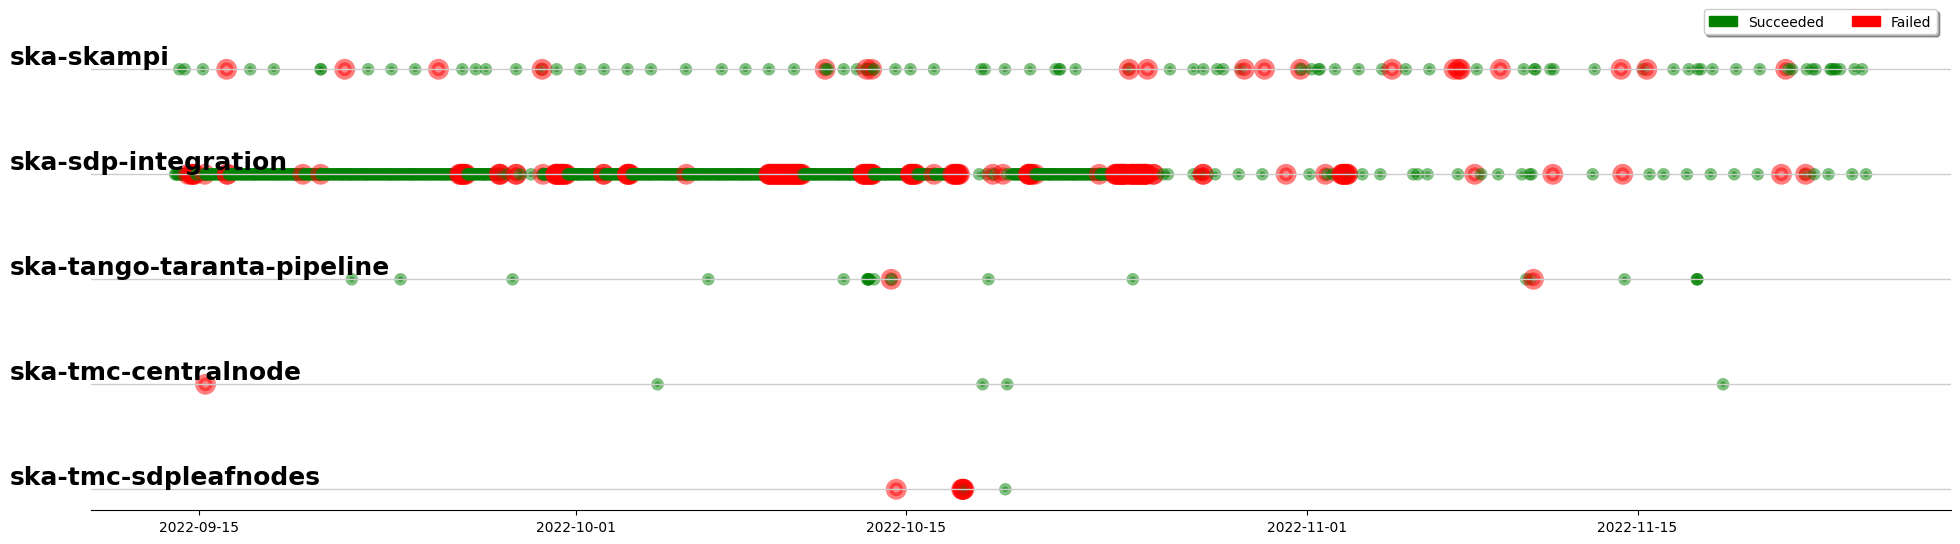

In [41]:
# https://stackoverflow.com/questions/44951911/plot-a-binary-timeline-in-matplotlib

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
# plt.title('MVP and Component Pipeline Health over PI', fontsize=20, color='cornflowerblue', loc='left')
ax.yaxis.set_visible(False)
ax.get_yaxis().set_ticklabels([])

handles = []
handle = mpatches.Patch(color='green', label='Succeeded')
handles.append(handle)
handle = mpatches.Patch(color='red', label='Failed')
handles.append(handle)
    
ax.legend(
    handles=handles, 
    ncol=len(handles), loc='upper center', bbox_to_anchor=(0.93, 1.10),
          fancybox=True, shadow=True)

#Stile ticks
# fig.autofmt_xdate()


cnt = 0
for proj in projects:
    data = df_mvp_pipelines[df_mvp_pipelines.project == proj]
    cnt = cnt + 1
    pos = cnt*2
    ax.scatter(
        data['time'].tolist(),
        [pos] * data.shape[0],
        c=data['colour'].tolist(),
        s=data['size'].tolist(),
        marker='o',
        linewidth=5,
        alpha=.5)
    
    ax.axhline(
        pos, 
        linewidth=1,
        c='#CCCCCC')
    
    min_date = df_mvp_pipelines['time'].min()
    days = timedelta(days=7)
    ax.annotate(
        proj.split('/')[-1], 
        (min_date - days, pos),
        fontsize=18, annotation_clip=False, verticalalignment='bottom', fontweight='bold')
    
fig.set_size_inches(24, 6)
# ax.get_yaxis().set_visible(False)
# ax.axis('off')
fig
#Hide spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)


In [12]:

query_api = client.query_api()
df_pipelines_all = query_api.query_data_frame(
    """from(bucket: "gitlab_metrics") 
        |> range(start: {0[start]}, stop: {0[finish]}) 
        |> filter(fn: (r) => r._measurement == "pipelines")
        |> drop(columns:["_measurement", "_start", "_stop", "table", "result", "index"])
        |> group()""".format(current_pi))

df_pipelines_all["project_id"] = pd.to_numeric(df_pipelines_all["project_id"])
df_pipelines_all = df_pipelines_all[df_pipelines_all.project_id.isin(project_ids)].reset_index()
# df_pipelines_all[df_pipelines_all.project == "ska-telescope/ska-skampi"]
df_pipelines_all['project'] = df_pipelines_all['project'].str[14:]
df_pipelines_all


/home/piers/.cache/pypoetry/virtualenvs/ska-cicd-gitlab-metrics-rcCqCUGS-py3.10/lib/python3.10/site-packages/influxdb_client/client/warnings.py:31: MissingPivotFunction:

The query doesn't contains the pivot() function.

The result will not be shaped to optimal processing by pandas.DataFrame. Use the pivot() function by:

    from(bucket: "gitlab_metrics") 
        |> range(start: 2022-09-14T00:00:00Z, stop: 2022-12-13T23:59:59Z) 
        |> filter(fn: (r) => r._measurement == "pipelines")
        |> drop(columns:["_measurement", "_start", "_stop", "table", "result", "index"])
        |> group() |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

You can disable this warning by:
    import warnings
    from influxdb_client.client.warnings import MissingPivotFunction

    warnings.simplefilter("ignore", MissingPivotFunction)

For more info see:
    - https://docs.influxdata.com/resources/videos/pivots-in-flux/
    - https://docs.influxdata.com/flux/latest/stdlib/un

index   result  table                            _time  _value  \
0         22  _result      0 2022-10-25 06:41:50.330000+00:00     0.0   
1         25  _result      0 2022-10-18 11:25:12.947000+00:00     0.0   
2         27  _result      0 2022-11-16 14:40:28.954000+00:00     0.0   
3         29  _result      0 2022-09-22 15:03:39.416000+00:00     0.0   
4         30  _result      0 2022-09-27 14:25:11.836000+00:00     0.0   
...      ...      ...    ...                              ...     ...   
14017  45637  _result      0 2022-10-13 10:03:36.505000+00:00     0.0   
14018  45638  _result      0 2022-10-13 15:18:20.118000+00:00     0.0   
14019  45639  _result      0 2022-10-14 08:36:38.557000+00:00     0.0   
14020  45641  _result      0 2022-11-14 10:51:02.517000+00:00     0.0   
14021  45642  _result      0 2022-10-21 11:31:55.592000+00:00    32.0   

             _field       created_by passed pipeline_id  \
0          coverage  ElisabettaGiani  False   676007000   
1          coverage  ElisabettaGiani   True   669713016   
2          coverage  ElisabettaGiani   True   696512962   
3          coverage  GianlucaMarotta  False   648010156   
4          coverage  GianlucaMarotta  False   651910498   
...             ...              ...    ...         ...   
14017  test_success         widaborz  False   665744549   
14018  test_success         widaborz  False   666105395   
14019  test_success         widaborz  False   666641227   
14020  test_success         widaborz  False   693778291   
14021  test_success         widaborz   True   673244935   

                                                 project  project_id     ref  \
0                                        ska-csp-lmc-low    25588162  master   
1                                        ska-csp-lmc-mid    25578388  master   
2                                        ska-csp-lmc-mid    25578388  master   
3                                        ska-csp-lmc-mid    25578388  master   
4                                        ska-csp-lmc-low    25588162  master   
...                                                  ...         ...     ...   
14017  ska-tango-taranta-group/ska-tango-taranta-pipe...    32606296    main   
14018  ska-tango-taranta-group/ska-tango-taranta-pipe...    32606296    main   
14019  ska-tango-taranta-group/ska-tango-taranta-pipe...    32606296    main   
14020  ska-tango-taranta-group/ska-tango-taranta-pipe...    32606296    main   
14021                                         ska-skampi    11448712  master   

         status  
0        failed  
1       success  
2       success  
3        failed  
4        failed  
...         ...  
14017   success  
14018   success  
14019  canceled  
14020   success  
14021   success  

[14022 rows x 13 columns]

In [13]:
import numpy as np
pass_rate_table = pd.pivot_table(df_pipelines_all[df_pipelines_all.status == "success"], values='_value', index=['project', '_time'],
                    columns=['_field'], aggfunc=np.sum)
pass_rate_table

_field                                                         coverage  \
project                      _time                                        
low-cbf/ska-low-cbf          2022-09-14 11:24:31.398000+00:00       0.0   
                             2022-09-27 11:24:36.428000+00:00       0.0   
                             2022-10-21 06:24:34.850000+00:00       0.0   
                             2022-10-24 03:41:40.644000+00:00       0.0   
                             2022-10-26 23:24:29.806000+00:00       0.0   
...                                                                 ...   
ska-tmc/ska-tmc-sdpleafnodes 2022-10-17 07:57:37.424000+00:00       0.0   
                             2022-10-17 08:26:29.987000+00:00       0.0   
                             2022-10-17 08:31:02.017000+00:00       0.0   
                             2022-10-17 10:02:48.319000+00:00       0.0   
                             2022-10-19 04:49:25.857000+00:00       0.0   

_field                                                         duration  \
project                      _time                                        
low-cbf/ska-low-cbf          2022-09-14 11:24:31.398000+00:00    1874.0   
                             2022-09-27 11:24:36.428000+00:00    1798.0   
                             2022-10-21 06:24:34.850000+00:00    2136.0   
                             2022-10-24 03:41:40.644000+00:00    2124.0   
                             2022-10-26 23:24:29.806000+00:00    1750.0   
...                                                                 ...   
ska-tmc/ska-tmc-sdpleafnodes 2022-10-17 07:57:37.424000+00:00     700.0   
                             2022-10-17 08:26:29.987000+00:00     672.0   
                             2022-10-17 08:31:02.017000+00:00     670.0   
                             2022-10-17 10:02:48.319000+00:00     750.0   
                             2022-10-19 04:49:25.857000+00:00     754.0   

_field                                                             last_run  \
project                      _time                                            
low-cbf/ska-low-cbf          2022-09-14 11:24:31.398000+00:00  1.663155e+09   
                             2022-09-27 11:24:36.428000+00:00  1.664278e+09   
                             2022-10-21 06:24:34.850000+00:00  1.666333e+09   
                             2022-10-24 03:41:40.644000+00:00  1.666583e+09   
                             2022-10-26 23:24:29.806000+00:00  1.666827e+09   
...                                                                     ...   
ska-tmc/ska-tmc-sdpleafnodes 2022-10-17 07:57:37.424000+00:00  1.665993e+09   
                             2022-10-17 08:26:29.987000+00:00  1.665995e+09   
                             2022-10-17 08:31:02.017000+00:00  1.665995e+09   
                             2022-10-17 10:02:48.319000+00:00  1.666001e+09   
                             2022-10-19 04:49:25.857000+00:00  1.666155e+09   

_field                                                         pass_rate  \
project                      _time                                         
low-cbf/ska-low-cbf          2022-09-14 11:24:31.398000+00:00      100.0   
                             2022-09-27 11:24:36.428000+00:00      100.0   
                             2022-10-21 06:24:34.850000+00:00      100.0   
                             2022-10-24 03:41:40.644000+00:00      100.0   
                             2022-10-26 23:24:29.806000+00:00      100.0   
...                                                                  ...   
ska-tmc/ska-tmc-sdpleafnodes 2022-10-17 07:57:37.424000+00:00      100.0   
                             2022-10-17 08:26:29.987000+00:00      100.0   
                             2022-10-17 08:31:02.017000+00:00      100.0   
                             2022-10-17 10:02:48.319000+00:00      100.0   
                             2022-10-19 04:49:25.857000+00:00      100.0   

_field                         

In [14]:
df_test_results = df_pipelines_all[["_time", "_field", "_value", "status", "project"]].reset_index()
df_test_results = df_test_results.rename(columns={"_time": "time", "_value": "value", "_field": "field"})
df_test_results.sort_values(by=['project', 'time', 'field'], ascending=[True, True, True], inplace=True)
# df_test_results['colour'] = df_test_results['status'].apply(lambda x: 'green' if x == 'success' else 'red')
# df_test_results['size'] = df_test_results['status'].apply(lambda x: 4 ** 2 if x == 'success' else 10 ** 2)
df_test_results

index                             time         field         value  \
1068    1068 2022-09-14 11:24:31.398000+00:00      coverage  0.000000e+00   
2626    2626 2022-09-14 11:24:31.398000+00:00      duration  1.874000e+03   
4184    4184 2022-09-14 11:24:31.398000+00:00      last_run  1.663155e+09   
5742    5742 2022-09-14 11:24:31.398000+00:00     pass_rate  1.000000e+02   
7300    7300 2022-09-14 11:24:31.398000+00:00    test_count  1.800000e+01   
...      ...                              ...           ...           ...   
6478    6478 2022-10-19 04:49:25.857000+00:00    test_count  6.300000e+01   
8036    8036 2022-10-19 04:49:25.857000+00:00    test_error  0.000000e+00   
9594    9594 2022-10-19 04:49:25.857000+00:00   test_failed  0.000000e+00   
11152  11152 2022-10-19 04:49:25.857000+00:00  test_skipped  0.000000e+00   
12710  12710 2022-10-19 04:49:25.857000+00:00  test_success  6.300000e+01   

        status                       project  
1068   success           low-cbf/ska-low-cbf  
2626   success           low-cbf/ska-low-cbf  
4184   success           low-cbf/ska-low-cbf  
5742   success           low-cbf/ska-low-cbf  
7300   success           low-cbf/ska-low-cbf  
...        ...                           ...  
6478   success  ska-tmc/ska-tmc-sdpleafnodes  
8036   success  ska-tmc/ska-tmc-sdpleafnodes  
9594   success  ska-tmc/ska-tmc-sdpleafnodes  
11152  success  ska-tmc/ska-tmc-sdpleafnodes  
12710  success  ska-tmc/ska-tmc-sdpleafnodes  

[14022 rows x 6 columns]

In [15]:
projects = df_test_results['project'].unique()
projects = list(reversed(["ska-skampi"] + sorted(list(filter(lambda x: not x == "ska-skampi", projects)))))
projects

['ska-tmc/ska-tmc-sdpleafnodes',
 'ska-tmc/ska-tmc-centralnode',
 'ska-tango-taranta-group/ska-tango-taranta-pipeline',
 'ska-sim-dishmaster',
 'ska-mid-cbf-mcs',
 'ska-dish-lmc',
 'ska-csp-lmc-mid',
 'ska-csp-lmc-low',
 'sdp/ska-sdp-integration',
 'low-cbf/ska-low-cbf',
 'ska-skampi']

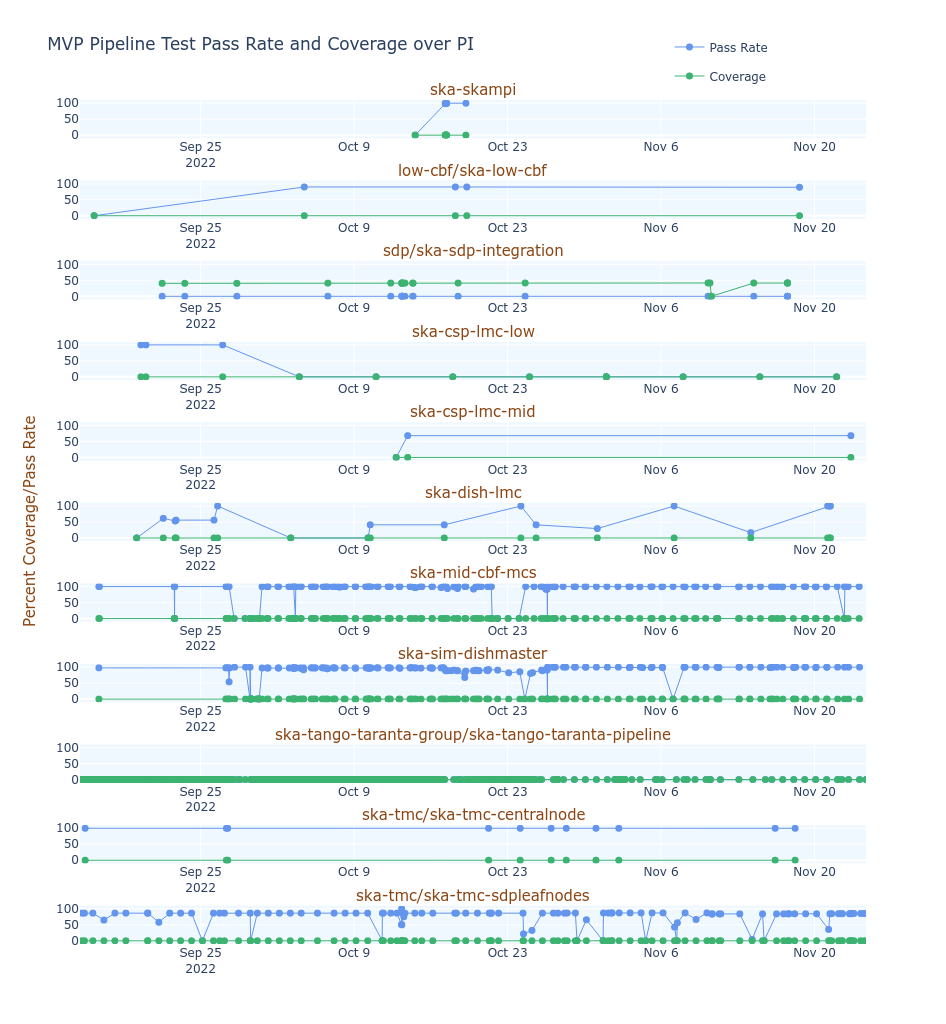

In [16]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=len(projects), 
                    cols=1, 
                    vertical_spacing = 0.05, 
                    subplot_titles = list(reversed(projects)),
                    y_title='Percent Coverage/Pass Rate',)

cnt = 0
yesno = True
for proj in projects:
    data_pass_rate = df_test_results[(df_test_results.project == proj) & (df_test_results.field == 'pass_rate')]
    data_coverage = df_test_results[(df_test_results.project == proj) & (df_test_results.field == 'coverage')]
    cnt = cnt + 1
    # pos = cnt*2
    fig.append_trace(go.Scatter(
        x=data_pass_rate.time, y=data_pass_rate.value, mode='markers+lines', marker=dict(size=7), line=dict(color='cornflowerblue', width=1),
     name="Pass Rate", showlegend=yesno,legendgroup="group1"), row=cnt, col=1)
    fig.append_trace(go.Scatter(
        x=data_coverage.time, y=data_coverage.value, mode='markers+lines', marker=dict(size=7), line=dict(color='mediumseagreen', width=1),
     name="Coverage", showlegend=yesno, legendgroup="group2"), row=cnt, col=1)
    fig.update_xaxes(range=[df_test_results.time.min(), df_test_results.time.max()], row=cnt, col=1)
    fig.update_yaxes(range=[-10, 110], row=cnt, col=1)
    yesno = False

fig.update_layout(height=1024, width=1024,
                  title_text="MVP Pipeline Test Pass Rate and Coverage over PI",
                  plot_bgcolor='aliceblue',
                  showlegend=True, legend=dict(
                                            yanchor="top",
                                            y=1.08,
                                            xanchor="left",
                                            x=0.75
                                        ))
fig.update_annotations(font=dict(size=15, color="saddlebrown"))
fig.show()
    

In [17]:
df =  df_pipelines_all[(df_pipelines_all.project == "ska-skampi") & (df_pipelines_all.status == "success")]
df = df[["_time", "_field", "_value", "status", "project"]].reset_index()
df = df.rename(columns={"_time": "time", "_value": "value", "_field": "field"})
df[(df.field != "coverage") & (df.field != "duration") & (df.field != "last_run")]

index                             time         field      value   status  \
261   4885 2022-11-17 16:14:46.740000+00:00     pass_rate  84.444444  success   
262   4887 2022-11-01 12:38:29.988000+00:00     pass_rate  87.179487  success   
263   4888 2022-11-23 05:20:23.438000+00:00     pass_rate  84.782609  success   
264   4889 2022-09-14 09:50:59.442000+00:00     pass_rate  86.486486  success   
265   4890 2022-09-26 17:57:21.957000+00:00     pass_rate  86.486486  success   
..     ...                              ...           ...        ...      ...   
778  14007 2022-10-21 12:28:36.828000+00:00  test_success  32.000000  success   
779  14008 2022-10-28 10:25:22.115000+00:00  test_success  33.000000  success   
780  14009 2022-11-17 13:19:23.579000+00:00  test_success  38.000000  success   
781  14011 2022-11-21 13:17:55.909000+00:00  test_success  39.000000  success   
782  14021 2022-10-21 11:31:55.592000+00:00  test_success  32.000000  success   

        project  
261  ska-skampi  
262  ska-skampi  
263  ska-skampi  
264  ska-skampi  
265  ska-skampi  
..          ...  
778  ska-skampi  
779  ska-skampi  
780  ska-skampi  
781  ska-skampi  
782  ska-skampi  

[522 rows x 6 columns]

In [18]:
import gitlab
from datetime import datetime
current_timestamp = int(datetime.now().timestamp())
query_api = client.query_api()
#  and r.status == "success"
df_testing = query_api.query_data_frame(
    """from(bucket: "gitlab_metrics") 
        |> range(start: {0[start]}, stop: {0[finish]}) 
        |> filter(fn: (r) => r._measurement == "pipelines")
        |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
        |> drop(columns:["_measurement",  "_time", "_start", "_stop", "passed", "status", "ref",
                         "duration", "last_run", "project", "project_id", "coverage", "test_error", "test_failed"])
        |> group()""".format(current_pi))
df_testing["tests_run"] = df_testing.test_count - df_testing.test_skipped
# df_testing = df_testing[(df_testing.tests_run > 0) & (df_testing.test_success > 0)]
df_testing.pass_rate = df_testing.test_success / df_testing.tests_run
df_testing = df_testing[["created_by", "pipeline_id", "pass_rate", "tests_run", "test_success"]].reset_index()
# df_testing[(df_testing.pass_rate < 1.0)]
df_testing = df_testing[["created_by", "pass_rate", "tests_run", "test_success"]].groupby(['created_by']).agg(['count', 'size', 'nunique', 'sum', 'mean']).reset_index()
df_testing['count'] = df_testing['pass_rate']['count']
df_testing['total_pass_rate'] = df_testing['pass_rate']['sum'].map('{:,.2f}'.format)
df_testing['mean_pass_rate'] = df_testing['pass_rate']['mean'] * 100
df_testing['mean_pass_rate'] = df_testing['mean_pass_rate'].map('{:,.2f} %'.format)
df_testing['total_tests_run'] = df_testing['tests_run']['sum'].map('{:,.0f}'.format)
df_testing['total_test_success'] = df_testing['test_success']['sum']
df_testing = df_testing[["created_by", "count", "total_pass_rate", "mean_pass_rate", "total_tests_run", "total_test_success"]]
df_testing.sort_values(by=['count'], ascending=[False], inplace=True)
df_topN = df_testing.head(10).reset_index()
gl = gitlab.Gitlab()
names = []
for index, row in df_topN.iterrows():
    user = gl.users.list(username=str(row["created_by"].iloc[0]).strip())
    names.append(user[0].name)
df_topN["Author"] = names
        
df_topN = df_topN[["Author", "count", "total_pass_rate", "mean_pass_rate", "total_tests_run"]].rename(columns={"count": "Test runs", "total_pass_rate": "Pass Rate(Sum)", "mean_pass_rate": "Pass Rate(Mean)", "total_tests_run": "Total Tests"})
df_topN.style.hide_index()\
    .set_properties(subset=['Author'], **{'text-align': 'left'})\
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}])\
    .set_caption('Top 10 Testers')\
    .set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '16px'),
        ('font-weight', 'bold'),
        ('text-align', 'center')
    ]}])


/tmp/ipykernel_888242/2861802585.py:37: FutureWarning:

this method is deprecated in favour of `Styler.hide(axis="index")`



In [19]:
from datetime import datetime
current_timestamp = int(datetime.now().timestamp())
query_api = client.query_api()
#  and r.status == "success"
df_testing = query_api.query_data_frame(
    """from(bucket: "gitlab_metrics") 
        |> range(start: {0[start]}, stop: {0[finish]}) 
        |> filter(fn: (r) => r._measurement == "pipelines")
        |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
        |> drop(columns:["_measurement",  "_time", "_start", "_stop", "passed", "status", "ref",
                         "duration", "last_run", "coverage", "test_error", "test_failed"])
        |> group()""".format(current_pi))
df_testing["tests_run"] = df_testing.test_count - df_testing.test_skipped
# df_testing = df_testing[(df_testing.tests_run > 0) & (df_testing.test_success > 0)]
df_testing.pass_rate = df_testing.test_success / df_testing.tests_run
df_testing = df_testing[["project", "project_id", "pass_rate", "tests_run", "test_success"]].reset_index()
# df_testing[(df_testing.pass_rate < 1.0)]
df_testing = df_testing[["project", "pass_rate", "tests_run", "test_success"]].groupby(['project']).agg(['count', 'size', 'nunique', 'sum', 'mean']).reset_index()
df_testing['count'] = df_testing['pass_rate']['count']
df_testing['total_pass_rate'] = df_testing['pass_rate']['sum'].map('{:,.2f}'.format)
df_testing['mean_pass_rate'] = df_testing['pass_rate']['mean'] * 100
df_testing['mean_pass_rate'] = df_testing['mean_pass_rate'].map('{:,.2f} %'.format)
df_testing['total_tests_run'] = df_testing['tests_run']['sum'].map('{:,.0f}'.format)
df_testing['total_test_success'] = df_testing['test_success']['sum']
df_testing = df_testing[["project", "count", "total_pass_rate", "mean_pass_rate", "total_tests_run", "total_test_success"]]
df_testing.sort_values(by=['count'], ascending=[False], inplace=True)
df_topN = df_testing.head(10).reset_index()
df_topN = df_topN[["project", "count", "total_pass_rate", "mean_pass_rate", "total_tests_run"]].rename(columns={"count": "Test runs", "project": "Project", "total_pass_rate": "Pass Rate(Sum)", "mean_pass_rate": "Pass Rate(Mean)", "total_tests_run": "Total Tests"})
df_topN.style.hide_index()\
    .set_properties(subset=['Project'], **{'text-align': 'left'})\
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}])\
    .set_caption('Top 10 Project Testers')\
    .set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '16px'),
        ('font-weight', 'bold'),
        ('text-align', 'center')
    ]}])


/tmp/ipykernel_888242/3922575067.py:29: FutureWarning:

this method is deprecated in favour of `Styler.hide(axis="index")`

